# **Homework 12 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:15

接下來，設置好 virtual display，並引入所有必要的套件。

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# 請不要更改 random seed !!!!
# 不然在judgeboi上 你的成績不會被reproduce !!!!

In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [ ]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

fix(env, seed)

In [ ]:
import time
start = time.time()

In [ ]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
box2d-py==2.3.8
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
cftime==1.5.0
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.

## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [ ]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super(PolicyGradientNetwork, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 4)
        self.acf = nn.ReLU()

    def forward(self, state):
        hid = self.acf(self.fc1(state))
        hid = self.acf(self.fc2(hid))
        return F.softmax(self.fc3(hid), dim=-1)

In [ ]:
class Critic(nn.Module):

    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 1)
        self.acf = nn.ReLU()

    def forward(self, state):
        value = self.acf(self.fc1(state))
        value = self.acf(self.fc2(value))
        value = self.fc3(value)
        return value

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [ ]:

class PolicyGradientAgent():
    
    def __init__(self, actor, critic):
        self.actor = actor
        self.critic = critic
        self.optimizerA = optim.Adam(self.actor.parameters(), lr=0.001)
        self.optimizerC = optim.Adam(self.critic.parameters(), lr=0.001)
         
    def forward(self, state):
        return self.actor(state), self.critic(state)

    def judge(self, state):
        state = torch.FloatTensor(state)
        return self.critic(state)

    def learn(self, log_probs, returns, values):
        values = values.view(-1)
        advantage = returns - values
        loss_actor = -(log_probs * advantage.detach()).sum() 
        loss_critic = advantage.pow(2).sum()

        self.optimizerA.zero_grad()
        self.optimizerC.zero_grad()
        loss_actor.backward()
        loss_critic.backward()
        self.optimizerA.step()
        self.optimizerC.step()
        
    def sample(self, state):
        action_prob = self.actor(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.actor.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.actor.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])


最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [ ]:
def evaluate(agent):
  fix(env, seed)
  agent.actor.eval()  
  NUM_OF_TEST = 5 
  test_total_reward = []
  action_list = []
  for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    total_reward = 0

    done = False
    while not done:
        action, _ = agent.sample(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)

        total_reward += reward

    #print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) #儲存你測試的結果
    
  agent.actor.train()

  return np.mean(test_total_reward), action_list

In [ ]:
actor = PolicyGradientNetwork()
critic = Critic()
agent = PolicyGradientAgent(actor,critic)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [ ]:
agent.actor.train()  
agent.critic.train()

EPISODE_PER_BATCH = 1  
NUM_BATCH = 3500       
factor = 0.995
avg_total_rewards, avg_final_rewards = [], []
best_score = 0
best_action = None
prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards, values = [], [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

            action, log_prob = agent.sample(state) # at , log(at|st)
            value = agent.judge(state)
            next_state, reward, done, _ = env.step(action)

            log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
            # seq_rewards.append(reward)
            state = next_state
            total_reward += reward
            total_step += 1
            seq_rewards.append(reward) 
            values.append(value)
            # ! 重要 ！
            # 現在的reward 的implementation 為每個時刻的瞬時reward, 給定action_list : a1, a2, a3 ......
            #                                                       reward :     r1, r2 ,r3 ......
            # medium：將reward調整成accumulative decaying reward, 給定action_list : a1,                         a2,                           a3 ......
            #                                                       reward :     r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,r3+0.99*r4+0.99^2*r5+ ......
            # boss : implement DQN
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                returns = []
                R = 0
                for r in reversed(seq_rewards):
                  R = r + factor*R
                  returns.insert(0,R)

                rewards.extend(returns)

                break  
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    agent.learn(torch.stack(log_probs), torch.from_numpy(rewards), torch.stack(values))
    if batch%50 == 0 or batch > (NUM_BATCH - 500):
      score, action_list = evaluate(agent)
      print('evaluate rewards:{:.3f}'.format(score))
      if score > best_score:
        best_score = score
        best_action = action_list

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


evaluate rewards:-172.633
evaluate rewards:-201.915
evaluate rewards:-172.008
evaluate rewards:-262.426
evaluate rewards:-109.850
evaluate rewards:-155.914
evaluate rewards:-120.599
evaluate rewards:-52.092
evaluate rewards:-67.520
evaluate rewards:-95.555
evaluate rewards:-8.634
evaluate rewards:-19.093
evaluate rewards:-3.725
evaluate rewards:-0.528
evaluate rewards:-12.259
evaluate rewards:12.339
evaluate rewards:38.991
evaluate rewards:59.917
evaluate rewards:93.172
evaluate rewards:86.087
evaluate rewards:13.140
evaluate rewards:119.171
evaluate rewards:105.839
evaluate rewards:64.369
evaluate rewards:104.317
evaluate rewards:130.320
evaluate rewards:-32.339
evaluate rewards:190.369
evaluate rewards:74.979
evaluate rewards:97.671
evaluate rewards:210.208
evaluate rewards:138.985
evaluate rewards:44.461
evaluate rewards:121.353
evaluate rewards:132.188
evaluate rewards:114.038
evaluate rewards:137.030
evaluate rewards:143.598
evaluate rewards:103.937
evaluate rewards:117.429
evalua

In [ ]:
best_score

280.0508555974373

In [ ]:
print('best score:',best_score)
PATH = "Action_List_test.npy" 
np.save(PATH ,np.array(best_action)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

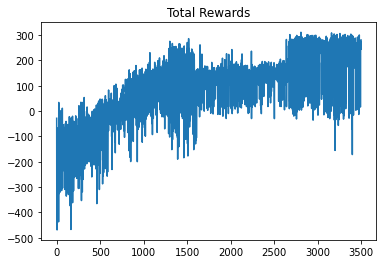

In [ ]:
end = time.time()
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

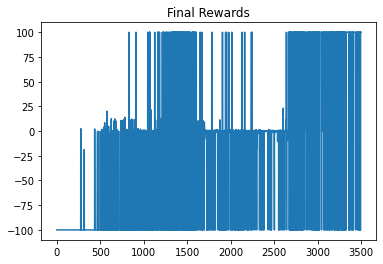

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()


訓練時間


## 測試

In [ ]:
fix(env, seed)
agent.actor.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action, _ = agent.sample(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Action list 的長相

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2, 3, 3, 1, 2, 3, 2, 3, 0, 2, 2, 3, 3, 2, 3, 2, 2, 2, 0, 3, 3, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 3, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 3, 1, 1, 2, 2, 2, 1, 3, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 2, 1, 3, 1, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 2, 1, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 3, 2, 3, 3, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1, 3, 2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 3, 0, 0, 3, 0, 0, 1, 3, 2, 2, 0, 2, 1, 3, 2, 2, 3, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1, 3, 1, 1, 3, 3, 2, 3, 2, 1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 3, 2, 2, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Action 的分布


In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

儲存 Model Testing的結果


In [ ]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
